In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import string

from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn. linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [3]:
# Load the training data

train_path = "/Users/saps/Desktop/Genre Classification Dataset/train_data.txt"
train_data = pd.read_csv(train_path, sep=':::', names=['Title', 'Genre', 'Description'], engine='python' )
train_data.head(5)

,Title,Genre,Description
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [4]:
# Load the test data

test_path = "/Users/saps/Desktop/Genre Classification Dataset/test_data.txt"
test_data = pd.read_csv(test_path, sep=':::', names=['Id', 'Title', 'Description'], engine='python')
test_data.head (5)

,Id,Title,Description
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),Before he was known internationally as a mart...


In [5]:
test_soln_path ="/Users/saps/Desktop/Genre Classification Dataset/test_data_solution.txt"
test_soln_data = pd.read_csv(test_soln_path, sep=':::', names=['Id', 'Title', 'Description'], engine='python' )
test_soln_data.drop(test_soln_data.columns[[0, 2]], axis=1, inplace=True)
test_soln_data.rename(columns = {'Title': 'Actual Genre'}, inplace= True)
test_soln_data.head (3)

,Actual Genre
1,thriller
2,comedy
3,documentary


In [6]:
#Count each genre value
train_data.Genre.value_counts()

 drama           13613
 documentary     13096
 comedy           7447
 short            5073
 horror           2204
 thriller         1591
 action           1315
 western          1032
 reality-tv        884
 family            784
 adventure         775
 music             731
 romance           672
 sci-fi            647
 adult             590
 crime             505
 animation         498
 sport             432
 talk-show         391
 fantasy           323
 mystery           319
 musical           277
 biography         265
 history           243
 game-show         194
 news              181
 war               132
Name: Genre, dtype: int64

Text(0, 0.5, 'Distribution of Genres')

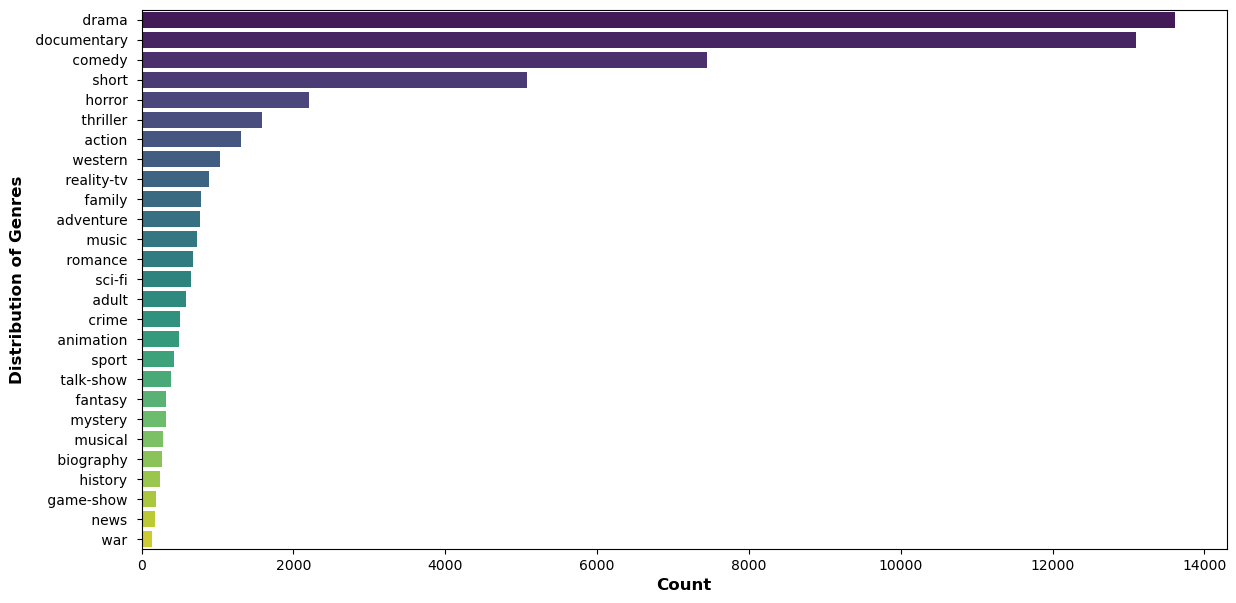

In [7]:
# Plot the distribution of genres in the training data
plt. figure(figsize=(14, 7))
sns.countplot(data=train_data, y='Genre',order=train_data['Genre'].value_counts().index, palette='viridis')
plt.xlabel('Count',fontsize=12, fontweight='bold')
plt.ylabel('Distribution of Genres', fontsize=12,fontweight= 'bold')

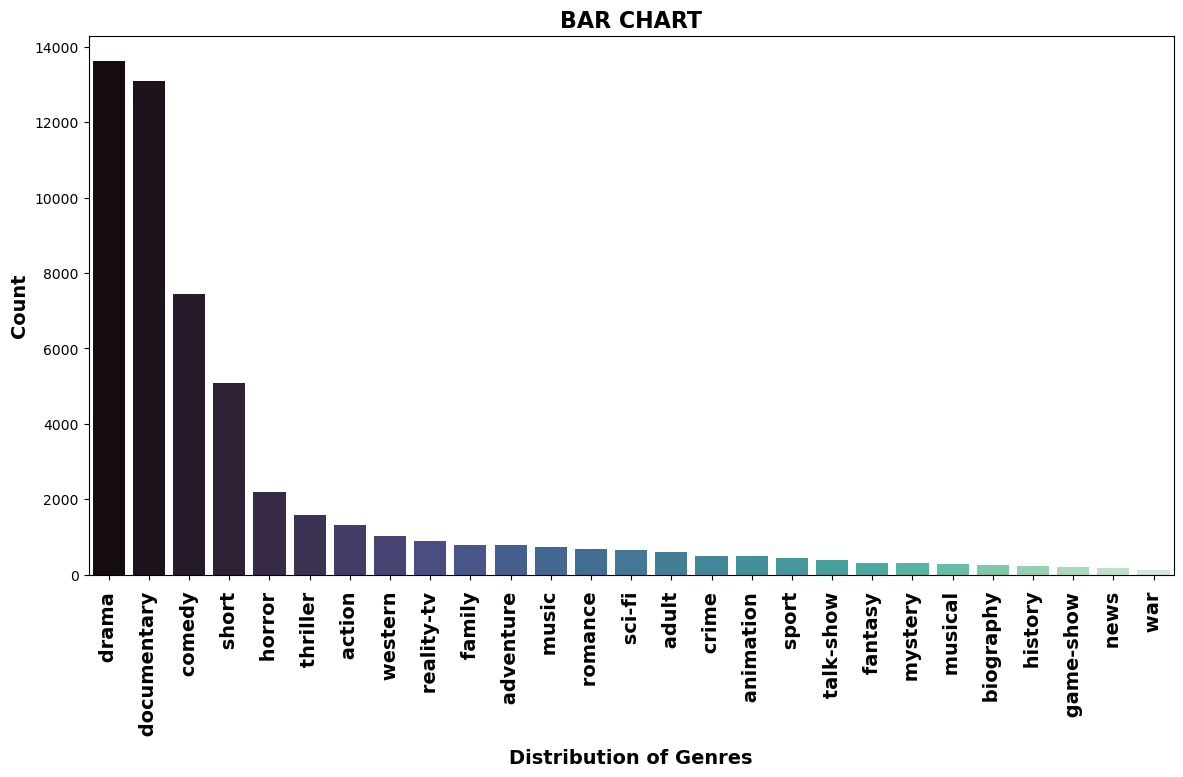

In [8]:
# Plot the distribution of genres using a bar plot
plt.figure(figsize=(14, 7))
counts = train_data[ 'Genre']. value_counts()
sns.barplot(x=counts.index, y=counts, palette='mako' )
plt.xlabel('Distribution of Genres', fontsize=14, fontweight= 'bold') 
plt. ylabel('Count',fontsize=14, fontweight='bold')
plt.title('BAR CHART', fontsize=16, fontweight='bold')
plt.xticks(rotation=90, fontsize=14, fontweight='bold')
plt. show()

In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54214 entries, 1 to 54214
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        54214 non-null  object
 1   Genre        54214 non-null  object
 2   Description  54214 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [10]:
train_data.isnull().sum()

Title          0
Genre          0
Description    0
dtype: int64

In [11]:
# Initialize the stemmer and stop words
stemmer = LancasterStemmer()
stop_words = set(stopwords.words('english'))



# Define the clean_text function
def clean_text(text):
    text = text.lower() # Lowercase all characters
    text = re.sub(r'@\S+', '',text) #Remove twitter handles
    text = re.sub(r'http\S+', '',text)#Remove URLs
    text = re.sub(r'pic.\S+', '',text)
    text = re.sub(r"[^a-zA-Z+]", '',text)#Keep only characters
    text = re.sub(r'\s+[a-zA-Z]\s+', '',text)#Keep words with length>1 only
    text="".join([i for i in text if i not in string.punctuation])
    words = nltk.word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english') # Remove stopwords
    text = " ".join([i for i in words if i not in stopwords and len(i) > 2])
    text = re.sub("\s[\s]+",'', text).strip() # Remove repeated/Leading/trailing spaces
    return text              

# Apply the clean_ text function to the 'Description' column in the training and test data
train_data['Text_cleaning'] = train_data['Description'].apply(clean_text)
test_data['Text_cleaning'] = test_data['Description'].apply(clean_text)

In [12]:
# Droping the redundant data
print ("shape before drop nulls",train_data. shape)
train_data = train_data.drop_duplicates()
print ("shape after drop nulls",train_data.shape)

shape before drop nulls (54214, 4)
shape after drop nulls (54214, 4)


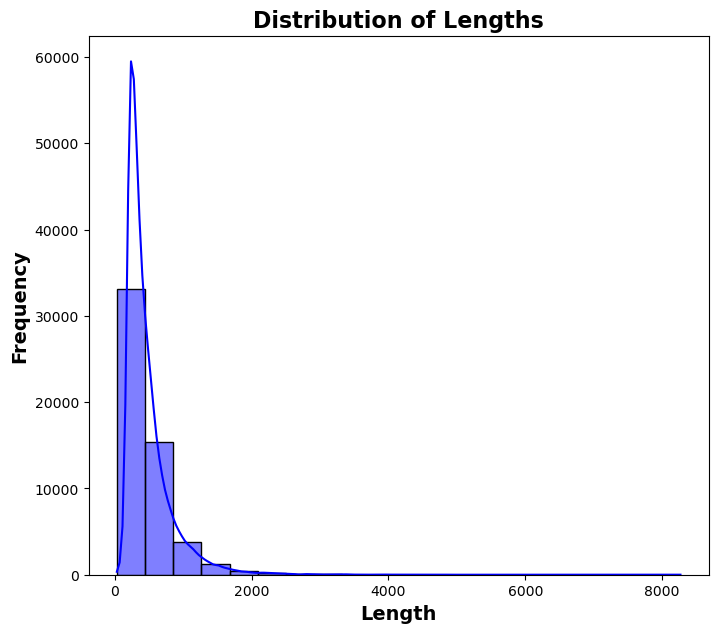

In [13]:
import warnings
warnings. filterwarnings("ignore", "use_inf_as_na")

# Calculate the length of cleaned text
train_data['length_Text_cleaning'] = train_data[ 'Text_cleaning'].apply(len)
#Visuolize the distribution of text lengths 
plt.figure(figsize=(8, 7))
sns.histplot (data=train_data, x='length_Text_cleaning', bins=20,kde=True, color='blue')
plt.xlabel('Length', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.title('Distribution of Lengths', fontsize=16, fontweight='bold')
plt. show()

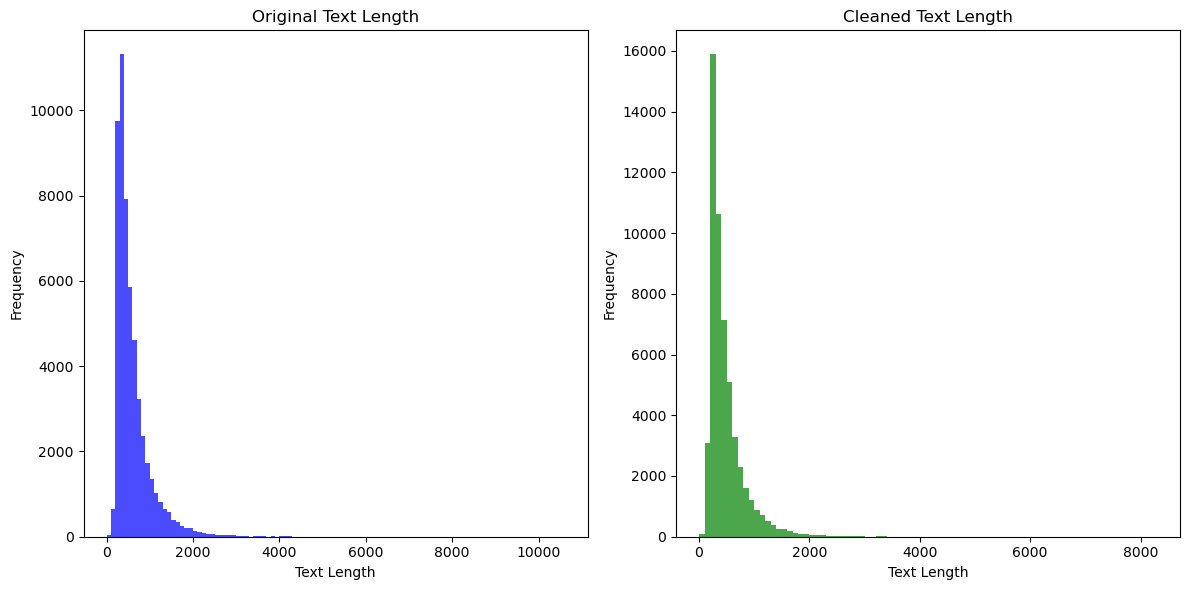

In [14]:
# Create histograms to visualize the distribution of text Lengths before and after cleaning

# Set up the figure with two subplots
plt. figure(figsize=(12, 6))

#Subplot 1: Original text Length distribution
plt.subplot(1, 2, 1)
original_lengths = train_data[ 'Description'].apply(len)
plt.hist(original_lengths, bins=range(0, max(original_lengths) + 100, 100), color='blue', alpha=0.7)
plt.title('Original Text Length')
plt.xlabel('Text Length' )
plt.ylabel( 'Frequency')
# Subplot 2: Cleaned text Length distribution
plt.subplot(1, 2, 2)
cleaned_lengths = train_data[ 'Text_cleaning'].apply(len)
plt.hist(cleaned_lengths, bins=range(0, max(cleaned_lengths) + 100, 100), color='green', alpha=0.7)
plt.title('Cleaned Text Length')
plt.xlabel('Text Length')
plt. ylabel('Frequency')
# Adjust layout and display the plots
plt. tight_layout()
plt. show()
            

In [15]:
# Initialize theTf-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()
# Fit and transform the training data
X_train = tfidf_vectorizer.fit_transform(train_data[ 'Text_cleaning'])
# Transform the test data
X_test = tfidf_vectorizer. transform(test_data['Text_cleaning'])

In [16]:
# Split the data into training and validation sets
X = X_train
y = train_data['Genre']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
import warnings
warnings. filterwarnings("ignore")

# Initialize and train a Multinomial Naive Bayes Classifier
clf_NB = MultinomialNB()
clf_NB.fit(X_train, y_train)

#Make predictions on the validotion set
y_pred = clf_NB.predict(X_val)


# Evaluate the performance of the model
accuracy = accuracy_score(y_val, y_pred)
print ("Validation Accuracy:", accuracy)
print (classification_report(y_val, y_pred))

Validation Accuracy: 0.2494697039564696
               precision    recall  f1-score   support

      action        0.00      0.00      0.00       263
       adult        0.00      0.00      0.00       112
   adventure        0.00      0.00      0.00       139
   animation        0.00      0.00      0.00       104
   biography        0.00      0.00      0.00        61
      comedy        0.50      0.00      0.01      1443
       crime        0.00      0.00      0.00       107
 documentary        0.56      0.00      0.00      2659
       drama        0.25      1.00      0.40      2697
      family        0.00      0.00      0.00       150
     fantasy        0.00      0.00      0.00        74
   game-show        0.00      0.00      0.00        40
     history        0.00      0.00      0.00        45
      horror        0.00      0.00      0.00       431
       music        0.00      0.00      0.00       144
     musical        0.00      0.00      0.00        50
     mystery        0.00

In [18]:
accuracy_NB = accuracy_score(y_val, y_pred)
accuracy_NB

0.2494697039564696

In [19]:
# Initialize and train a Logistic Regression Classifier
clf_logreg = LogisticRegression(multi_class='multinomial', solver='sag' )
clf_logreg. fit(X_train, y_train)
# Make predictions on the validation set
y_pred = clf_logreg.predict(X_val)

# Evaluate the performance of the model
accuracy=accuracy_score(y_val,y_pred)
print("Validation Accuracy:", accuracy)
print(classification_report(y_val, y_pred))
   

Validation Accuracy: 0.2502075071474684
               precision    recall  f1-score   support

      action        0.00      0.00      0.00       263
       adult        0.00      0.00      0.00       112
   adventure        0.00      0.00      0.00       139
   animation        0.00      0.00      0.00       104
   biography        0.00      0.00      0.00        61
      comedy        0.50      0.00      0.01      1443
       crime        0.00      0.00      0.00       107
 documentary        0.56      0.00      0.00      2659
       drama        0.25      1.00      0.40      2697
      family        0.00      0.00      0.00       150
     fantasy        0.00      0.00      0.00        74
   game-show        0.00      0.00      0.00        40
     history        0.00      0.00      0.00        45
      horror        0.00      0.00      0.00       431
       music        1.00      0.01      0.03       144
     musical        0.00      0.00      0.00        50
     mystery        0.00

In [20]:
accuracy_logreg = accuracy_score(y_val, y_pred)
accuracy_logreg

0.2502075071474684

In [21]:
# Use the trained model to make predictions on the test data
X_test_predictions = clf_NB.predict(X_test)
test_data['Predicted_Genre_NB'] = X_test_predictions

In [22]:
# Use the trained model to make predictions on the test data
X_test_predictions = clf_logreg.predict(X_test)
test_data['Predicted_Genre_LR'] = X_test_predictions

In [23]:
# Save the test_data Dataframe with predicted genres to a CSV file
test_data.to_csv('predicted_genres.csv', index=False)
# Add actual genre column to predicted dataFrame
extracted_col = test_soln_data["Actual Genre"]
test_data.insert(5, "Actual Genre", extracted_col)

In [24]:
test_data.head()

,Id,Title,Description,Text_cleaning,Predicted_Genre_NB,Actual Genre,Predicted_Genre_LR
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar...",lrbraneloveshislifehiscarhisapartmenthisjobbut...,drama,NaN,drama
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch...",spainmarchquicoisaverynaughtychildofthreebelon...,drama,thriller,drama
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...,oneyearinthelifeofalbinandhisfamilyofshepherds...,drama,comedy,drama
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi...",hisfatherhasdiedhehasntspokenwithhisbrotherfor...,drama,documentary,drama
4,5,Er nu zhai (1955),Before he was known internationally as a mart...,beforehewasknowninternationallyasamartialartss...,drama,drama,drama


In [35]:
count_same_values_NB = (test_data['Predicted_Genre_NB'] == test_data['Actual Genre' ]).sum ()
count_same_values_LR = (test_data[ 'Predicted_Genre_LR'] == test_data[ 'Actual Genre' ]).sum()


print ("Number of samples where Naive Bayes Classifier predicted accurately:", count_same_values_NB)
print ("Number of samples where Logistic Regression Classifier predicted accurately:", count_same_values_LR)

Number of samples where Naive Bayes Classifier predicted accurately: 13608
Number of samples where Logistic Regression Classifier predicted accurately: 13601


In [37]:
sum = accuracy_NB+ accuracy_logreg
size1 = (accuracy_NB/sum)
size2 =(accuracy_logreg/sum)

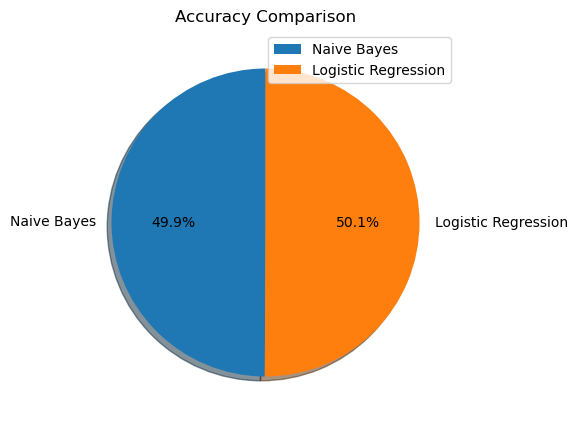

In [38]:
labels = ['Naive Bayes','Logistic Regression']
sizes = [size1, size2]

# Plotting the pie chart
plt. figure(figsize=(5,5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, shadow = True)
plt. title("Accuracy Comparison")
plt. legend()
plt. show()

In [41]:
sum = count_same_values_NB + count_same_values_LR
portion1 = (count_same_values_NB/ sum)
portion2 = (count_same_values_LR/sum)

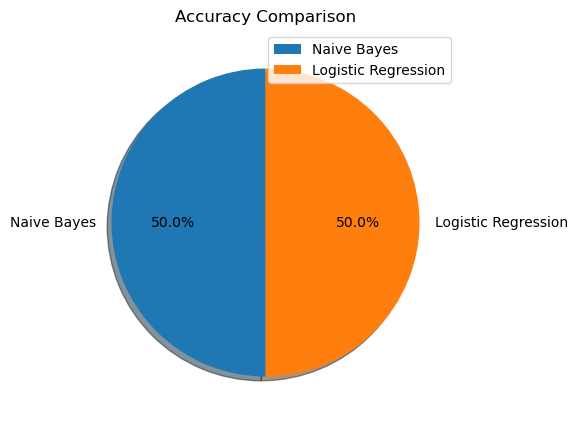

In [46]:
labels = ['Naive Bayes', 'Logistic Regression']
sizes = [portion1, portion2]
# Plotting the pie chart
plt. figure(figsize=(5,5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, shadow = True)
plt.title('Accuracy Comparison')
plt.legend()
plt.show()